# Case4 - Walmart Sales Predict

## 目標:藉由歷史資料來預測其未來的銷售量

# **Importing Modules**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import pickle 
from os import path

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 讀取資料集

In [2]:
data = pd.read_csv('./datasets/train.csv')
stores = pd.read_csv('./datasets/stores.csv')
features = pd.read_csv('./datasets/features.csv')

## 查看資料shape

**Training Dataset**

In [3]:
data.shape

(421570, 5)

In [4]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
data.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [6]:
data_1 = data.groupby(by=["Store","Dept"]).sum()

In [7]:
#Select 想要看的資料
data_1.query('Store == 1')
#data_1.query('Store == 1 and Dept == 1')

Weekly_Sales  IsHoliday
Store Dept                         
1     1       3219405.18         10
      2       6592598.93         10
      3       1880518.36         10
      4       5285874.09         10
      5       3468885.58         10
...                  ...        ...
      95     17270404.89         10
      96      4056723.46          9
      97      5034650.88         10
      98      1691371.22         10
      99        11325.37          5

[77 rows x 2 columns]

In [8]:
data_1["Weekly_Sales"]

Store  Dept
1      1       3219405.18
       2       6592598.93
       3       1880518.36
       4       5285874.09
       5       3468885.58
                  ...    
45     94       494496.46
       95      7564151.83
       96            5.94
       97       924775.55
       98        75767.27
Name: Weekly_Sales, Length: 3331, dtype: float64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


**Dataset containing info of Stores**

In [10]:
stores.shape

(45, 3)

In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [13]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


**Dataset containing additional data of Stores**

In [14]:
features.shape

(8190, 12)

In [15]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [16]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


# **Handling missing values of features dataset**

## cpi https://rich01.com/what-is-cpi-index/

In [18]:
features["CPI"].fillna(features["CPI"].median(),inplace=True)
features["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)

In [19]:
for i in range(1,6):
    features["MarkDown"+str(i)] = features["MarkDown"+str(i)].apply(lambda x: 0 if x < 0 else x)
    features["MarkDown"+str(i)].fillna(value=0,inplace=True)

In [20]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


# **Merging Training Dataset and merged stores-features Dataset**

In [21]:
data = pd.merge(data,stores,on='Store',how='left')

In [22]:
data = pd.merge(data,features,on=['Store','Date'],how='left')

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

In [24]:
data.sort_values(by=['Date'],inplace=True)

In [25]:
data.set_index(data.Date, inplace=True)

In [26]:
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()

True

In [27]:
data.drop(columns='IsHoliday_x',inplace=True)
data.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [28]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


# **Splitting Date Column**

In [29]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week

C:\Users\kevin\AppData\Local\Temp\ipykernel_37556\235201722.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['Date'].dt.week


In [30]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


# **Outlier Detection and Abnormalities**

**Outliers**

In [31]:
agg_data = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
agg_data.isnull().sum()

Store      0
Dept       0
max        0
min        0
mean       0
median     0
std       37
dtype: int64

In [32]:
store_data = pd.merge(left=data,right=agg_data,on=['Store', 'Dept'],how ='left')
store_data.dropna(inplace=True)
data = store_data.copy()
del store_data

In [33]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,0.0,0.0,...,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095


In [34]:
data['Total_MarkDown'] = data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5']
data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1,inplace=True)

In [35]:
numeric_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown']
data_numeric = data[numeric_col].copy()

In [36]:
data.shape

(421533, 20)

In [37]:
data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis = 1)]
data.shape

(375438, 20)

**Negative Weekly Sales**

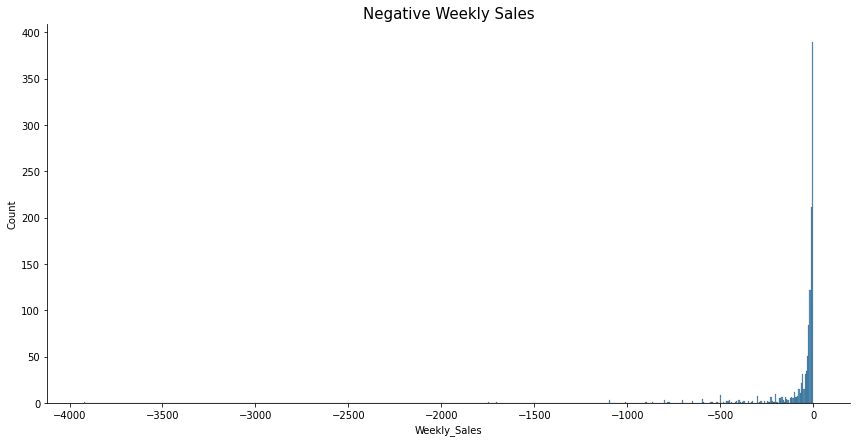

In [38]:
y = data["Weekly_Sales"][data.Weekly_Sales < 0]
sns.displot(y,height=6,aspect=2)
plt.title("Negative Weekly Sales", fontsize=15)
plt.savefig('plots/negative_weekly_sales.png')
plt.show()

In [39]:
data=data[data['Weekly_Sales']>=0]

In [40]:
data.shape

(374247, 20)

In [41]:
data['IsHoliday'] = data['IsHoliday'].astype('int')

In [42]:
data

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,57592.12,14537.37,22513.322937,18535.480,9854.349032,0.00
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,766.93,-9.92,372.655556,371.050,290.954675,0.00
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,2512.14,110.56,876.629441,824.040,307.436056,0.00
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,11990.43,7414.43,9188.915105,9161.970,756.223236,0.00
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,29166.26,4791.74,8607.050490,7571.600,3874.176095,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,2,26,2012-10-26,9258.88,A,202307,69.79,3.506,223.078337,6.170,0,2012,10,43,19679.04,4179.99,9347.725105,8762.990,2825.107609,9678.80
2012-10-26,38,23,2012-10-26,53.12,C,39690,65.95,4.301,131.193097,10.199,0,2012,10,43,289.78,3.50,37.848679,31.365,34.065601,502.88
2012-10-26,27,6,2012-10-26,5339.65,A,204184,58.99,4.071,142.762411,8.000,0,2012,10,43,41005.33,2524.01,7730.729091,6798.780,5178.928257,10969.27


In [43]:
#data.to_csv('./datasets/preprocessed_walmart_dataset.csv')

# **Data Visuallizations**

**Average Monthly Sales**

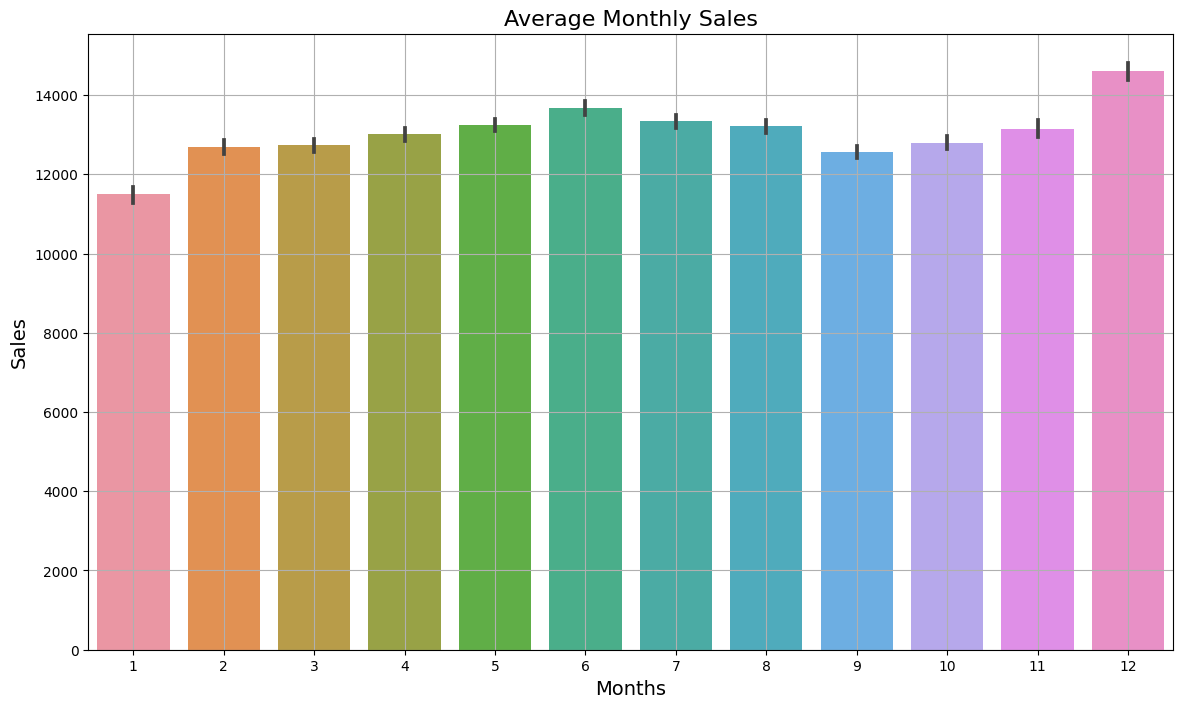

In [44]:
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.savefig('plots/avg_monthly_sales.png')
plt.grid()

**Average Weekly Sales Store wise**

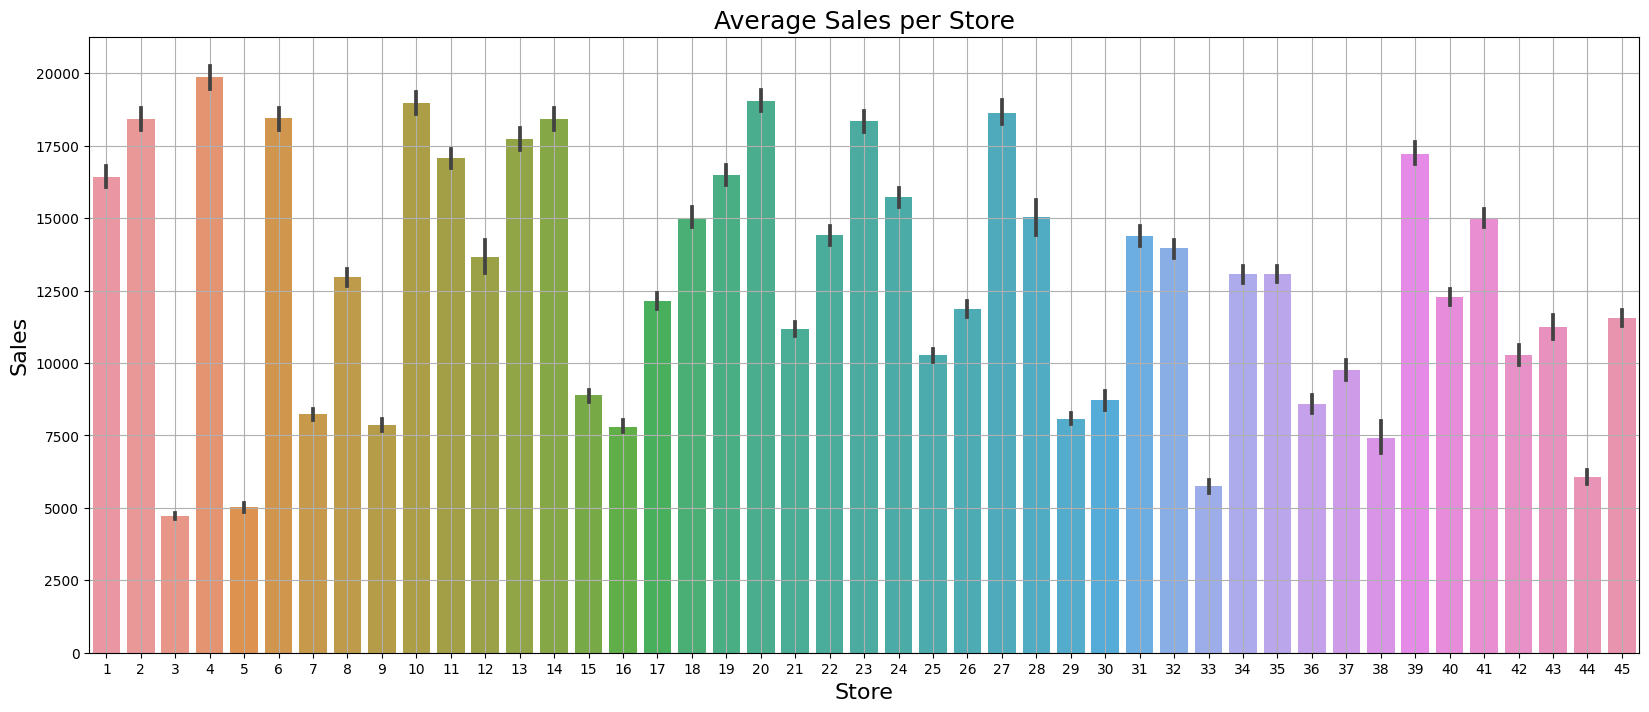

In [45]:
plt.figure(figsize=(20,8))
sns.barplot(x='Store',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.savefig('plots/avg_sales_store.png')
plt.show()

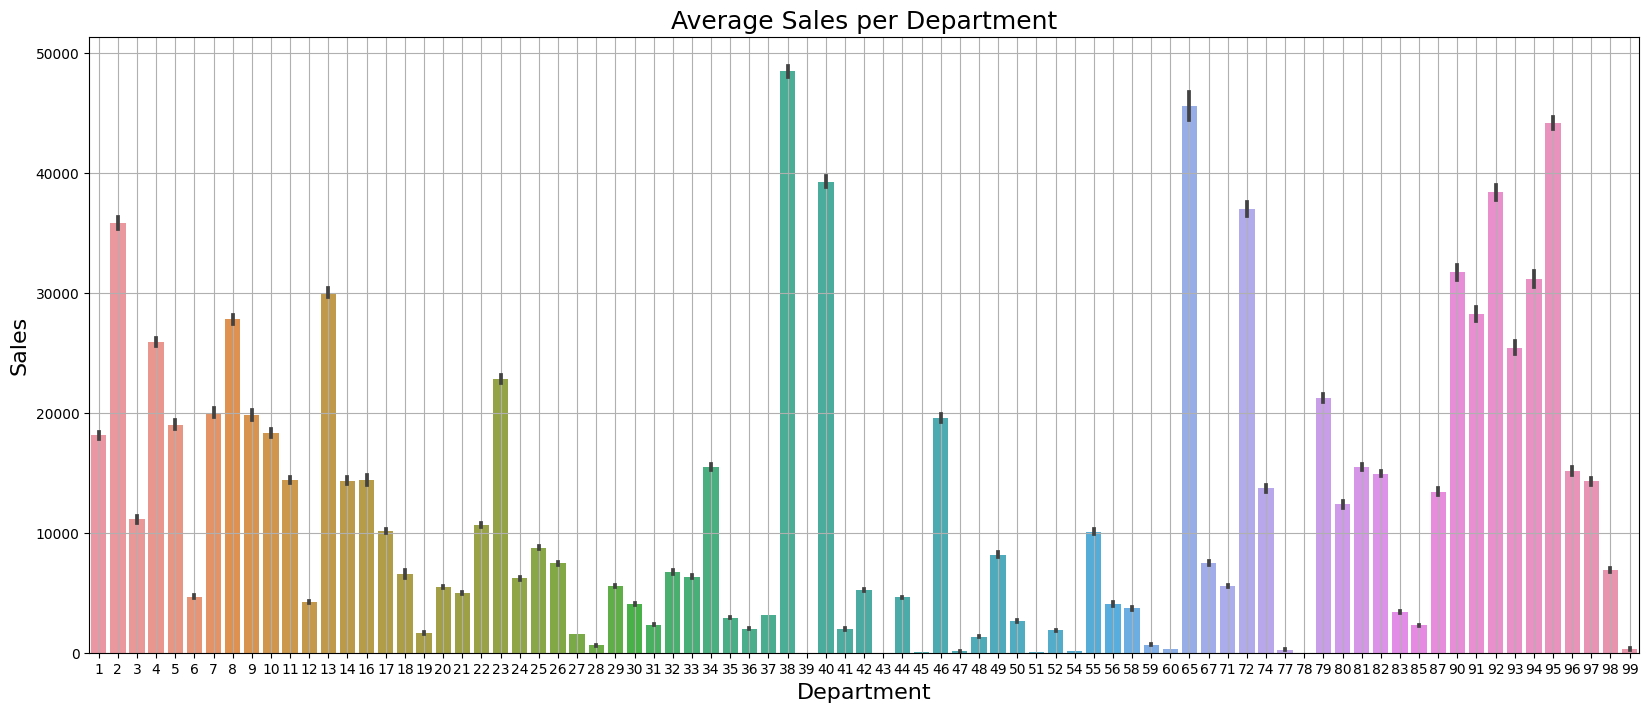

In [46]:
plt.figure(figsize=(20,8))
sns.barplot(x='Dept',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.savefig('plots/avg_sales_dept.png')
plt.show()

**Sales Vs Temperature**

C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


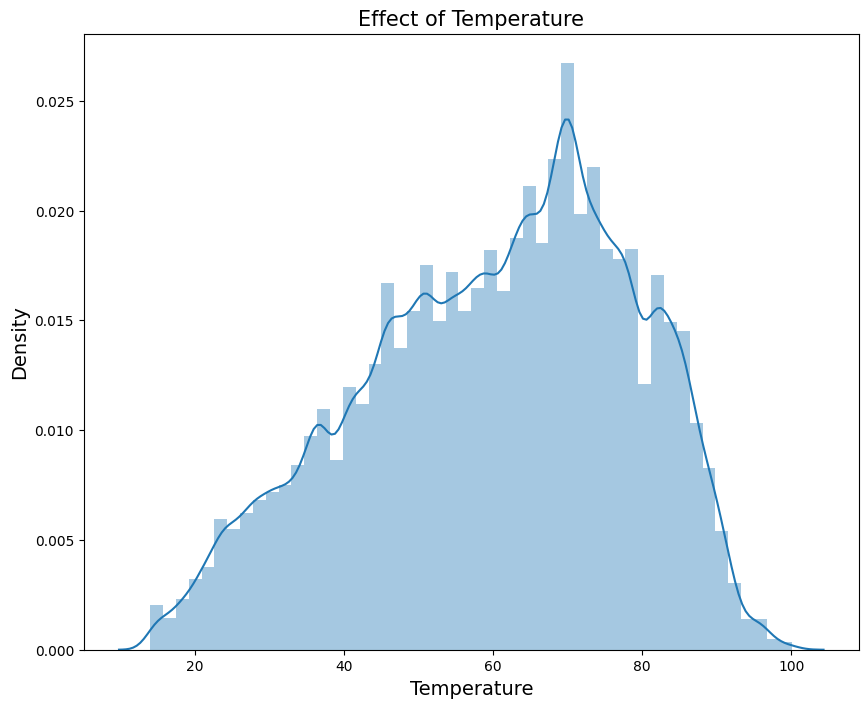

In [47]:
plt.figure(figsize=(10,8))
sns.distplot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.savefig('plots/effect_of_temp.png')
plt.show()

**Holiday Distribution**

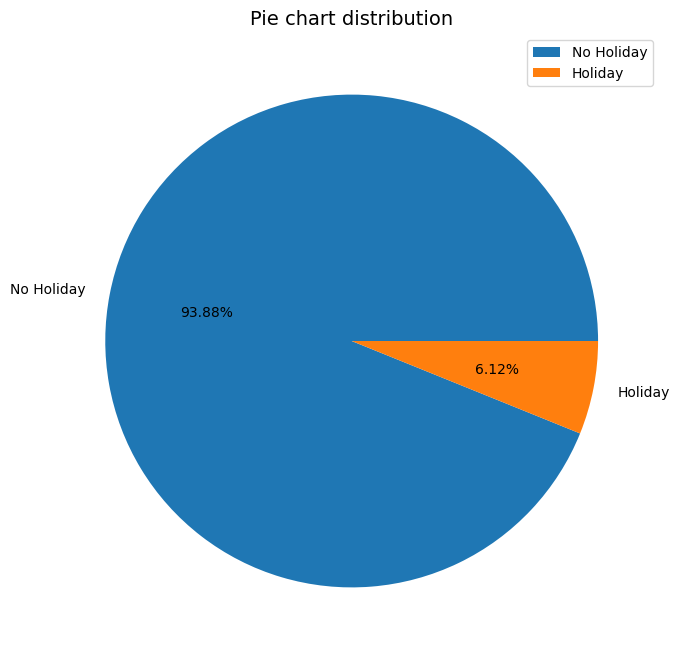

In [48]:
plt.figure(figsize=(8,8))
plt.pie(data['IsHoliday'].value_counts(),labels=['No Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=14)
plt.legend()
plt.savefig('plots/holiday_distribution.png')
plt.show()

#**Time Series Decompose**

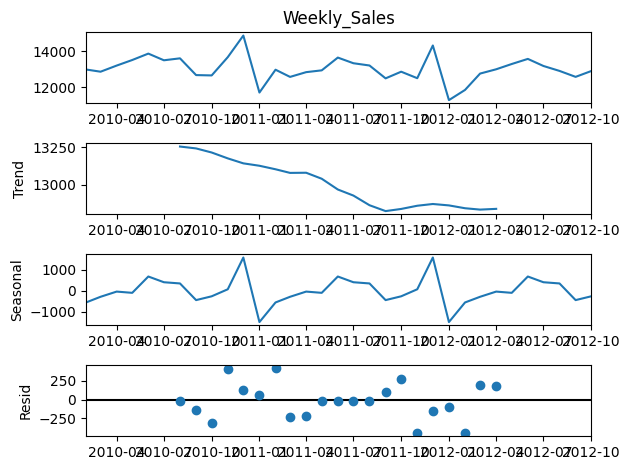

In [49]:
sm.tsa.seasonal_decompose(data['Weekly_Sales'].resample('MS').mean(), model='additive').plot()
plt.savefig('plots/seasonal_decompose.png')
plt.show()

# **One-hot-encoding**

In [50]:
cat_col = ['Store','Dept','Type']
data_cat = data[cat_col].copy()

In [51]:
data_cat.tail()

,Store,Dept,Type
Date,,,
2012-10-26,2,26,A
2012-10-26,38,23,C
2012-10-26,27,6,A
2012-10-26,36,40,A
2012-10-26,45,98,B


In [52]:
data_cat = pd.get_dummies(data_cat,columns=cat_col)

In [53]:
data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [54]:
data.shape

(374247, 20)

In [55]:
data = pd.concat([data, data_cat],axis=1)

In [56]:
data.shape

(374247, 149)

In [57]:
data.drop(columns=cat_col,inplace=True)

In [58]:
data.drop(columns=['Date'],inplace=True)

In [59]:
data.shape

(374247, 145)

# **Data Normalization**

In [60]:
num_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown','max','min','mean','median','std']

In [61]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [62]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


In [63]:
data = normalization(data.copy(),num_col)

In [64]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.342576,0.630267,0.328495,0.0501,0.840500,0.508787,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.009188,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0.009537,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0.118953,0.650636,0.233627,0.0501,0.873861,0.291286,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.152888,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


# **Correlation between features of dataset**

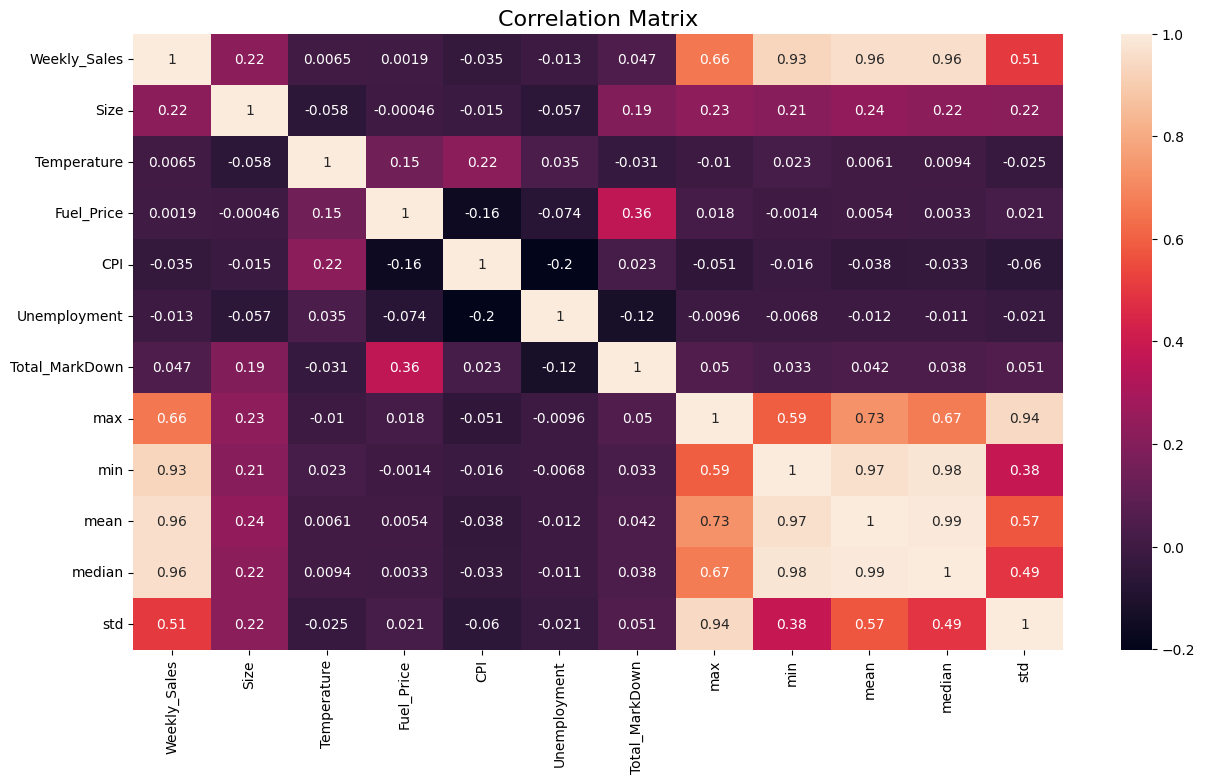

In [65]:
plt.figure(figsize=(15,8))
corr = data[num_col].corr()
sns.heatmap(corr,vmax=1.0,annot=True)
plt.title('Correlation Matrix',fontsize=16)
plt.savefig('plots/correlation_matrix.png')
plt.show()

# **Data Splitted into Training, Validation, Test**

In [66]:
X = data.drop(['Weekly_Sales'],axis=1)
Y = data.Weekly_Sales

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

# **Linear Regression Model**

In [68]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)

C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression(normalize=False)

In [69]:
lr_acc = lr.score(X_test,y_test)*100
print("Linear Regressor Accuracy - ",lr_acc)

Linear Regressor Accuracy -  92.31953401887503


In [70]:
y_pred = lr.predict(X_test)

In [71]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.03021044980814186
MSE 0.003467653805354356
RMSE 0.05888678803733785
R2 0.9231953545114341


In [72]:
lr_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#lr_df.to_csv('./predictions/lr_real_pred.csv')
lr_df

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.131922
2010-07-09,0.364278,0.291174
2011-07-01,0.005003,0.021909
2012-01-06,0.015856,0.012724
2011-08-26,0.000318,0.000429
...,...,...
2011-01-28,0.169068,0.231474
2010-08-20,0.252860,0.234435
2010-11-26,0.265617,0.316058


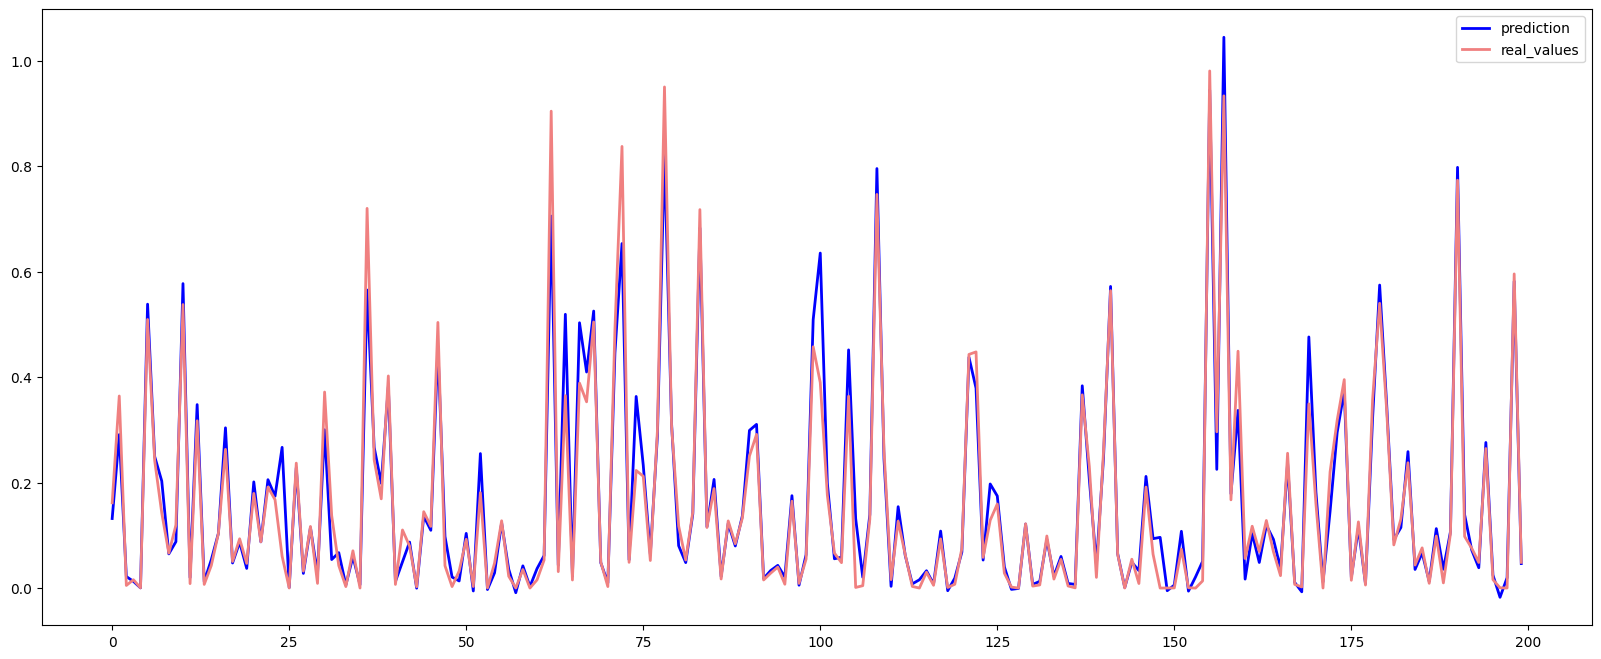

In [73]:
plt.figure(figsize=(20,8))
plt.plot(lr.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('plots/lr_real_pred.png')
plt.show()

# **Random Forest Regressor Model**

In [74]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [75]:
rf_acc = rf.score(X_test,y_test)*100
print("Random Forest Regressor Accuracy - ",rf_acc)

Random Forest Regressor Accuracy -  97.92007939582211


In [76]:
y_pred = rf.predict(X_test)

In [77]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.015382090181333765
MSE 0.0009390634130321295
RMSE 0.030644141577667493
R2 0.9792009210969329


In [78]:
rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#rf_df.to_csv('./predictions/rf_real_pred.csv')
rf_df

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.125969
2010-07-09,0.364278,0.325263
2011-07-01,0.005003,0.012689
2012-01-06,0.015856,0.020294
2011-08-26,0.000318,0.000565
...,...,...
2011-01-28,0.169068,0.179062
2010-08-20,0.252860,0.264728
2010-11-26,0.265617,0.374793


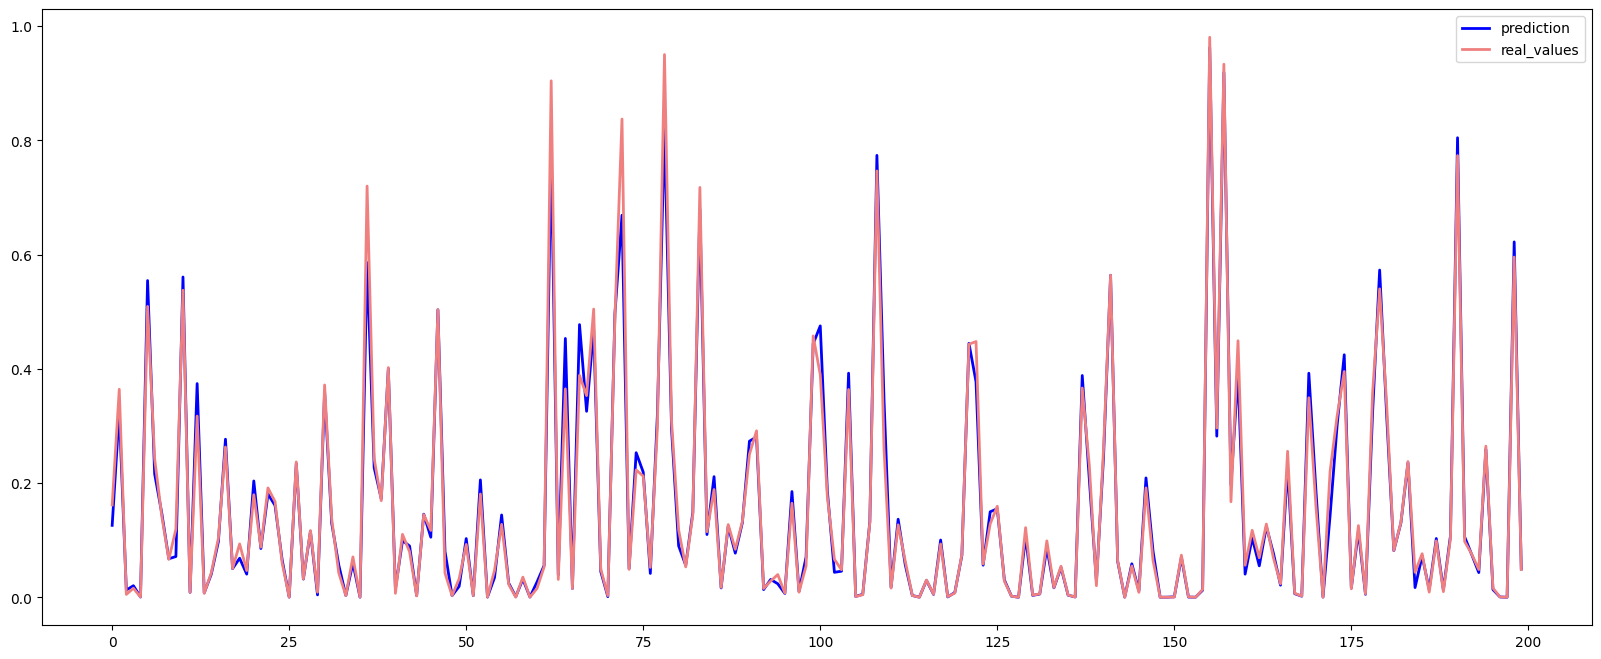

In [79]:
plt.figure(figsize=(20,8))
plt.plot(rf.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('plots/rf_real_pred.png')
plt.show()

# **XGboost Model**

In [80]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [81]:
xgb_acc = xgbr.score(X_test,y_test)*100
print("XGBoost Regressor Accuracy - ",xgb_acc)

XGBoost Regressor Accuracy -  97.4515606783296


In [82]:
y_pred = xgbr.predict(X_test)

In [83]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.019073863313481938
MSE 0.0011505949421848332
RMSE 0.03392042072535117
R2 0.9745157665335955


In [84]:
xgb_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#xgb_df.to_csv('./predictions/xgb_real_pred.csv')
xgb_df

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.156696
2010-07-09,0.364278,0.317071
2011-07-01,0.005003,0.020782
2012-01-06,0.015856,0.020422
2011-08-26,0.000318,0.002151
...,...,...
2011-01-28,0.169068,0.196538
2010-08-20,0.252860,0.250062
2010-11-26,0.265617,0.364054


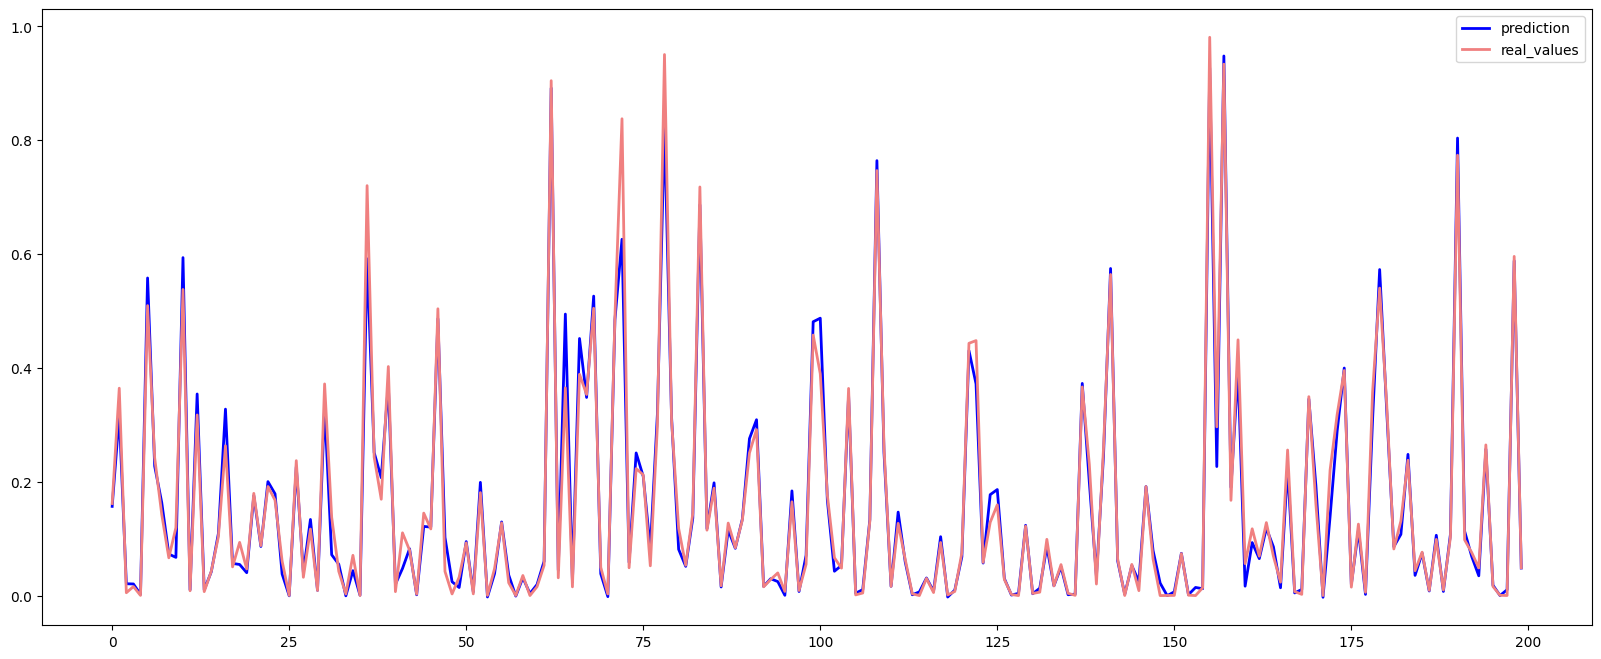

In [85]:
plt.figure(figsize=(20,8))
plt.plot(xgbr.predict(X_test[:200]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[:200].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.legend(loc="best")
plt.savefig('plots/xgb_real_pred.png')
plt.show()

# **Custom Deep Learning Neural Network**

In [86]:
def create_model():
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='normal',activation='relu'))
  model.add(Dense(32, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  return model

In [87]:
estimator_model = KerasRegressor(build_fn=create_model, verbose=1)

C:\Users\kevin\AppData\Local\Temp\ipykernel_37556\779415646.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_model = KerasRegressor(build_fn=create_model, verbose=1)


In [88]:
history = estimator_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=5000)

Epoch 1/100
48/48 [==============================] - 3s 11ms/step - loss: 0.8451 - val_loss: 0.1663
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.1600 - val_loss: 0.1771
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.1643 - val_loss: 0.1447
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.1634 - val_loss: 0.1717
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.1559 - val_loss: 0.2048
Epoch 6/100
48/48 [==============================] - 0s 5ms/step - loss: 0.1478 - val_loss: 0.1157
Epoch 7/100
48/48 [==============================] - 0s 5ms/step - loss: 0.1478 - val_loss: 0.1168
Epoch 8/100
48/48 [==============================] - 0s 5ms/step - loss: 0.1332 - val_loss: 0.1087
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2576 - val_loss: 0.3136
Epoch 10/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2667 - val_loss: 0.1601
Epoch 11

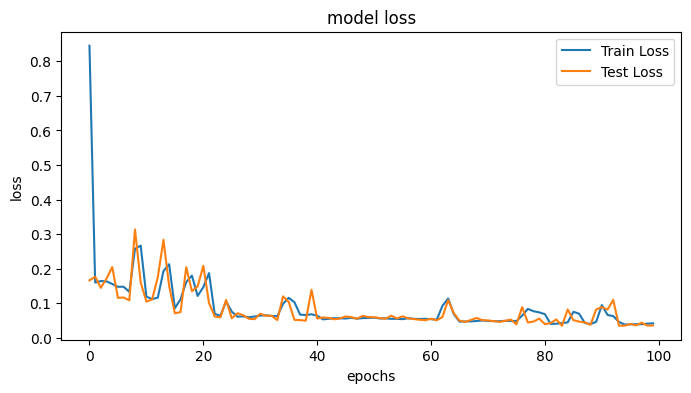

In [89]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('plots/dnn_loss.png')
plt.show()

In [90]:
dnn_acc = metrics.r2_score(y_pred, y_test)*100
print("Deep Neural Network accuracy - ",dnn_acc)

Deep Neural Network accuracy -  97.35132719534846


In [91]:
y_pred = estimator_model.predict(X_test)

2340/2340 [==============================] - 2s 940us/step


In [92]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.035884481031200816
MSE 0.004316792625957808
RMSE 0.06570230304911547
R2 0.9150560535170182


In [93]:
dnn_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#dnn_df.to_csv('./predictions/dnn_real_pred.csv')
dnn_df

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.106078
2010-07-09,0.364278,0.248766
2011-07-01,0.005003,0.006155
2012-01-06,0.015856,0.001475
2011-08-26,0.000318,0.002616
...,...,...
2011-01-28,0.169068,0.186575
2010-08-20,0.252860,0.211817
2010-11-26,0.265617,0.294424


4/4 [==============================] - 0s 2ms/step


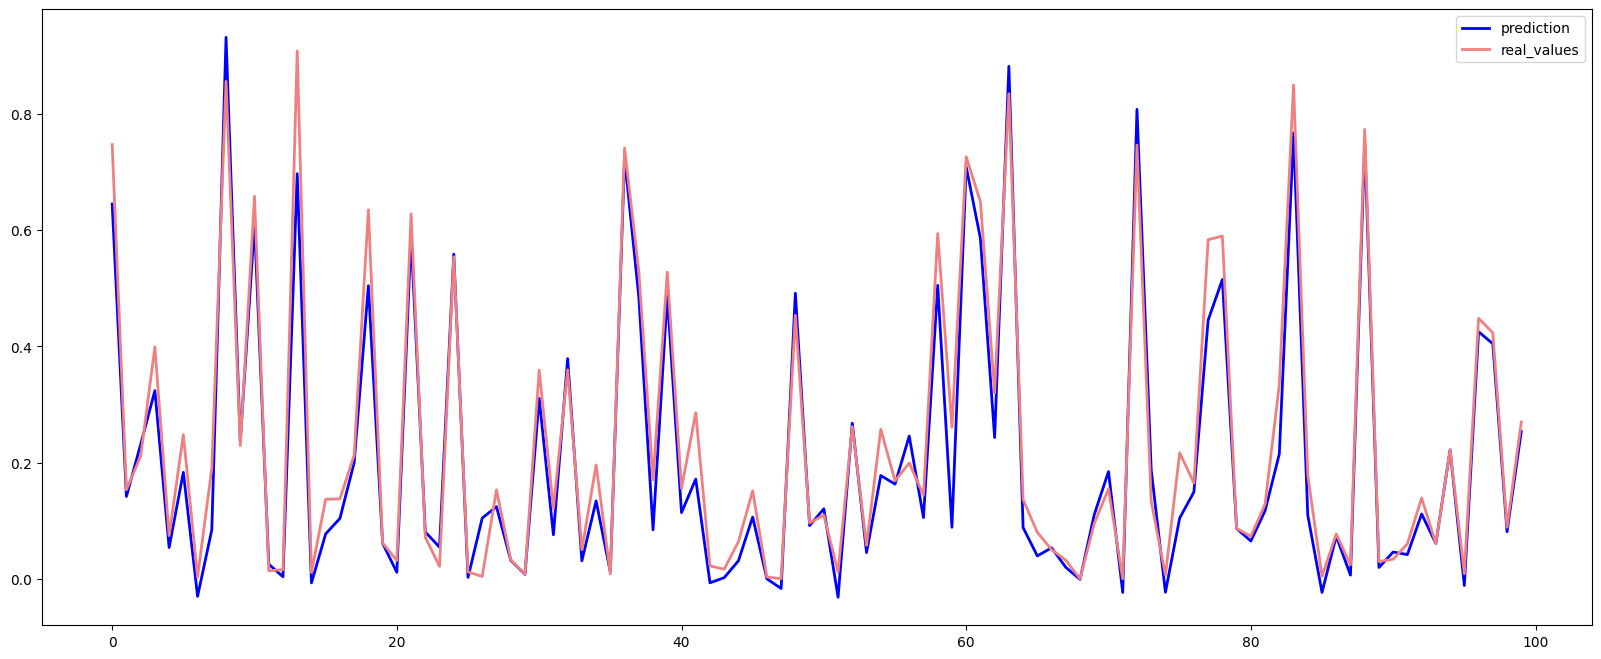

In [94]:
plt.figure(figsize=(20,8))
plt.plot(estimator_model.predict(X_test[200:300]), label="prediction", linewidth=2.0,color='blue')
plt.plot(y_test[200:300].values, label="real_values", linewidth=2.0,color='lightcoral')
plt.savefig('plots/dnn_real_pred.png')
plt.legend(loc="best")

# **Comparing Models**

In [95]:
acc = {'model':['lr_acc','rf_acc','xgb_acc','dnn_acc'],'accuracy':[lr_acc,rf_acc,xgb_acc,dnn_acc]}

In [96]:
acc_df = pd.DataFrame(acc)
acc_df

,model,accuracy
0,lr_acc,92.319534
1,rf_acc,97.920079
2,xgb_acc,97.451561
3,dnn_acc,97.351327


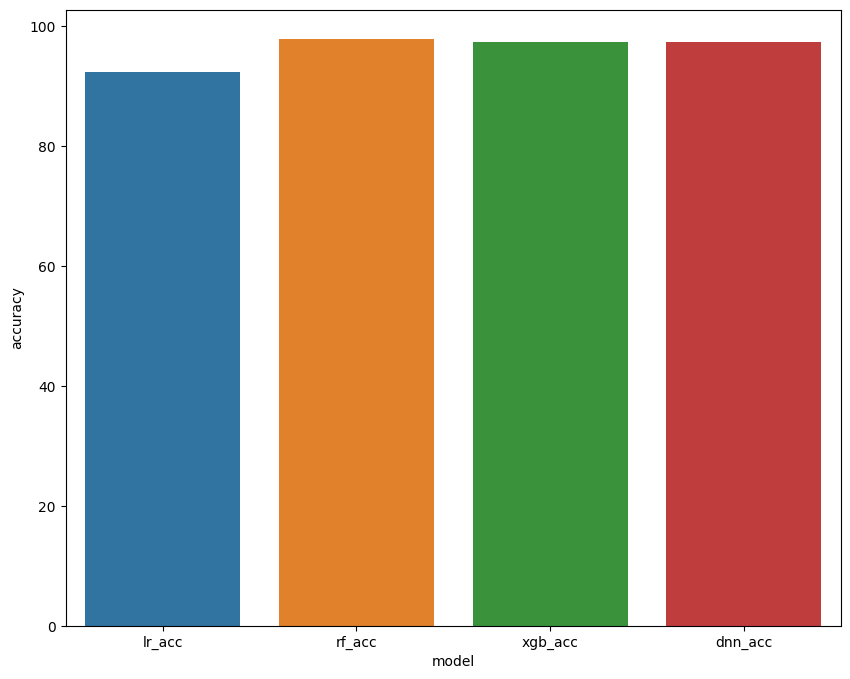

In [97]:
plt.figure(figsize=(10,8))
sns.barplot(x='model',y='accuracy',data=acc_df)
plt.savefig('plots/compared_models.png')
plt.show()